In [1]:
# Skylar Haskiell
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
from textwrap import wrap

from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# pull in data
df = pd.read_pickle("../../../data/prd/Paper/FR_meta_and_final_tokens_23DEC21.pkl")
#df = pd.read_pickle("../../../data/prd/Paper/FR_lemmas_22DEC21.pkl")

df.reset_index(inplace = True, drop = True)

In [3]:
df.head()

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens
0,89996,"This is a project to explore Game-based, Metap...",Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,1999467.0,1,project explore game base metaphor enhanced ga...
1,89997,Institution: Franklin Institute Science Museum...,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,1799699.0,1,institution franklin institute science museum ...
2,89998,Through programs (including small group conver...,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,1505858.0,1,program include small group conversation citiz...
3,89999,In partnership with the American Chemical Soci...,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,51000.0,1,partnership american chemical society acs nati...
4,90001,The Center for Molecular Interfacing (CMI) wil...,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,1519821.0,1,center molecular interfacing cmi enable integr...


In [4]:
df.shape

(1143869, 30)

In [5]:
# look thru raw abstracts

docs = df["final_tokens"]

term_match_data = []

# big_datum: 0 matches
for i, abstract in enumerate(docs):
        if ('big datum' in abstract or 'big data' in abstract or 'big_data' in abstract):
            term_match_data.append(i)

In [6]:
len(term_match_data)

4684

In [7]:
df["final_tokens"][term_match_data[0]]

'computer science 31this project aim improve big data preparedness diverse stem audience define comprehensive framework call tide timely introduction emerge data intensive computing project create certificate program provide method institutionalize framework develop project motivate guide collective experience grid computing solve domain specific problem life science environmental engineering data intensive computing receive attention solution address datum deluge bring tremendous advance distribute system internet base computing innovative programming model call mapreduce peta scale distribute file system support revolutionize fundamentally change approach large scale datum storage processing exist systematic approach teach big datum concept stem undergraduate tide address issue follow objective define set core competency require research advance field practical application design build system data intensive computing area define certificate program consist course effectively address 

In [8]:
df["ABSTRACT"][100]  #[term_match_data[4]]

"Enhanced Science of Science and Innovation Policy depends on better metrics. You can't manage what you can't measure.  This is particularly true for interdisciplinary research, which currently has few generally agreed-upon measures with acceptable degrees of accuracy.  Researchers at the University of Sussex have begun to address this problem by developing a conceptual framework to gauge research diversity.  The current project builds upon that conceptual framework to empirically test metrics that gauge the interdisciplinarity of particular bodies of research.  One proposed key measure assesses the degree to which particular research papers, or collections of such, integrate research knowledge from diverse research domains.  A second measure determines the degree of specialization of collections of research papers (e.g., those published by a particular research center or those of a research area such as quantum dots).  The resulting measures help track and characterize the emergence o

In [9]:
yrs_big_data = df["FY"][term_match_data].value_counts().sort_index(ascending=True)
print(yrs_big_data)

2009      6
2010      2
2011      5
2012     64
2013    194
2014    331
2015    490
2016    642
2017    683
2018    754
2019    761
2020    752
Name: FY, dtype: int64


<ipython-input-10-975acdfa48cb>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


Text(0.5, 1.0, 'Big Data Frequency by FY')

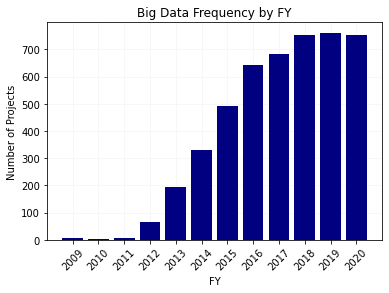

In [10]:
year = yrs_big_data.index.tolist()
count = yrs_big_data.values

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(year, count, color='navy')
#plt.xlim(-0.7, len(year)-0.3)
#plt.xlim(2007.3,2020.7)
plt.xticks(year, rotation=45)
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
#x_ticks = ax.xaxis.get_major_ticks()
#x_ticks[-1].label1.set_visible(False)
plt.xlabel("FY")
plt.ylabel("Number of Projects")
plt.title("Big Data Frequency by FY")

#plt.savefig("startyr_freq.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("startyr_freq.pdf", dpi = 800, bbox_inches = "tight")

In [11]:
dept_big_data = df["DEPARTMENT"][term_match_data].value_counts().sort_index(ascending=True)
print(dept_big_data)

DOD        7
EPA        1
HHS     2411
NASA       3
NSF     2219
USDA      30
VA        13
Name: DEPARTMENT, dtype: int64


In [12]:
df["DEPARTMENT"][term_match_data[2000]]

'HHS'

In [13]:
sum(~df["PROJECT_TERMS"].isna())

1096888

In [14]:
df["PROJECT_TERMS"][0].lower()

'achievement; analog; base; cognitive science; computer design; conceptual domain; data; data collection; design; educational process of instructing; ensure; environment; experience; goals; informatics; instruction; learning; maps; mediating; metaphor; methodology; methods; metric; modeling; motivation; perception; play; procedures; process; prototype; psyche structure; readiness; research; research infrastructure; route; science; structure; success; system; testing; theories; translating'

In [15]:
type(df["PROJECT_TERMS"][0]) == str

True

In [16]:
terms_idx = []

# big datum = 0, big_datum = 0, big_data = 0
for i, keywords in enumerate(df["PROJECT_TERMS"]):
    if type(keywords) == str:
        keywords = keywords.lower()
        if ('big data' in keywords): 
            terms_idx.append(i)
    else:
        pass

In [17]:
len(terms_idx)

5156

In [18]:
df["PROJECT_TERMS"][terms_idx[15]]

'abstracting; Address; American Heart Association; Area; base; Big Data; biomedical informatics; Biometry; Blood Pressure; Cardiovascular Diseases; cardiovascular disorder prevention; Cardiovascular system; career; Cause of Death; Cholesterol; cigarette smoking; cohort; Commit; comparative effectiveness; Coronary heart disease; cost effective; Country; Data; Development; Diabetes Mellitus; disability; disorder prevention; dissemination research; Educational Curriculum; Educational process of instructing; effectiveness research; Electronic Health Record; Environmental Policy; Epidemic; Epidemiology; Etiology; Faculty; Female; Funding Agency; Future; Generations; Genomics; Goals; Health; health care delivery; Health Professional; Health Promotion; Hypertension; imaging modality; implementation research; improved; Incidence; Insulin Resistance; interest; Investigation; Knowledge; Learning; Magnetic Resonance Imaging; Maintenance; Medical; member; metabolomics; Methods; Minority; mortality

In [19]:
df["ABSTRACT"][terms_idx[100]]

"We propose to create a massively scalable toolkit to enable large, multi-center Patient-centered Information Commons (PIC) at local, regional and, national scale, where the focus is the alignment of all available biomedical data per individual. Such a Commons is a prerequisite for conducting the large-N, Big Data, longitudinal studies essential for understanding causation in the Precision Medicine framework while simultaneously addressing key complexities of Patient Centric Outcome Research studies required under ACA (Affordable Care Act). This agenda entails the four following aims:  Aim 1: Create an individual patient data identification and retrieval toolkit that is robust across distributed data of wide variety and geographically scattered. Robustness with regard to a variety of organizational structures and national scalability is emphasized. Aim 2: Generate a complete diagnostic and prognostic 'data' picture of a patient across multiple sources of data, some of which are noisy a

In [20]:
# find abstracts labeled with "big data" and not including the words "big data"

proj_terms_not_in_abs = list(set(terms_idx).difference(set(term_match_data)))

In [21]:
len(proj_terms_not_in_abs)

1628

In [23]:
len(list(set(terms_idx).intersection(set(term_match_data))))

3528

In [22]:
df["ABSTRACT"][proj_terms_not_in_abs[20]]

"DESCRIPTION (provided by applicant): Commercially available heart sensors have been reported to last nearly 84 hours without needing battery replacements. These lifetimes are clearly not enough since long term monitoring for congenital heart diseases are typically prescribed for months if not years. Generative Model-based Resource Efficient ECG Monitoring (GeM-REM) leverages the morphologic predictability of ECG signals to considerably reduce wireless communication from a wearable ECG sensor to a desktop, laptop or a smart-phone and increases their lifetime by 40 fold. In principle, the GeMREM technique considers the periodicity of ECG signals and develops a generative model. The generative model if supplied with the correct parameters can generate synthetic physiological signals that are equivalent to the original signal in diagnostic content. Theoretical study with MIT BIH data shows that this technique can result in huge increase (40 fold) in lifetime and reduction in storage requi

In [25]:
in_abs_not_terms = list(set(term_match_data).difference(set(terms_idx)))

In [29]:
df["ABSTRACT"][in_abs_not_terms[1]]

'This project addresses the growing need for improved synchronization methods for large-scale, multi-party distributed systems.\xa0 As users migrate information to cloud storage, cloud providers may use multiple loosely consistent replicas because of the overhead of keeping replicas synchronized at all times.\xa0 Further, users themselves may create loosely synchronized replicas on laptops, tablets, or other devices when they are disconnected from the cloud storage.\xa0 Periodic synchronization, or reconciliation, becomes a requirement in such settings.Reconciliation has been most studied in the specific setting of two connected users, each containing a set of keys, and both desiring the union of the sets.\xa0 The costs of these protocols is typically in terms of the size of the symmetric set difference between the two sets.\xa0 The Principal Investigator (PI) will focus on generalizing reconciliation methods to settings where many parties communicate over a network represented by a gr

In [30]:
df["PROJECT_TERMS"][in_abs_not_terms[1]]

'Address; Algorithms; base; Code; Communication; Communities; computer science; cost; Data; Databases; Devices; Distributed Systems; Goals; Graph; improved; Information Systems; Information Theory; laptop; Measures; Methods; Principal Investigator; Protocols documentation; Provider; Scheme; Structure; Tablets; theories; Time; Work'

In [79]:
# look thru raw abstracts

docs = df["final_tokens"]

term_match_data2 = []

for i, abstract in enumerate(docs):
        if ('data mining' in abstract or 'datum mining' in abstract or 'data_mining' in abstract):
            term_match_data2.append(i)

In [80]:
len(term_match_data2)

3092

In [81]:
df["final_tokens"][term_match_data2[10]]

'project encourage interdisciplinary machine learn research education integrate use machine learn application area solve real science problem serve catalyst new research machine learning application domain investigate basic machine learn issue arise work real world application optimize choice available generate training datum assess improve quality training datum design specific algorithm method time series feature base datum develop method abstain classification research motivate go collaboration researcher create solution train artificial nose chemistry tufts land cover mapping remotely_sensed datum geography boston university classification sky survey astronomy harvard non invasive gluclose monitoring biomedical engineering tufts liquification prediction civil engineering tufts successful application machine learn task significant impact life human education initiative complementary goal educate computer science student conduct interdisciplinary machine learning research educate pro

In [82]:
yrs_data_mining = df["FY"][term_match_data2].value_counts().sort_index(ascending=True)
print(yrs_data_mining)

2008    258
2009    287
2010    258
2011    228
2012    225
2013    230
2014    254
2015    265
2016    240
2017    217
2018    226
2019    219
2020    185
Name: FY, dtype: int64


<ipython-input-84-deae1569af7f>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


Text(0.5, 1.0, 'Data Mining Frequency by FY')

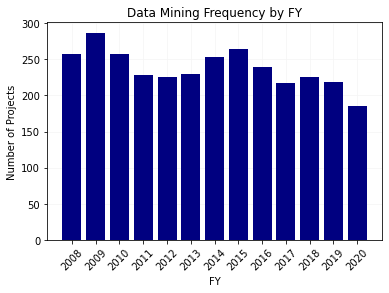

In [84]:
year = yrs_data_mining.index.tolist()
count = yrs_data_mining.values

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(year, count, color='navy')
#plt.xlim(-0.7, len(year)-0.3)
#plt.xlim(2007.3,2020.7)
plt.xticks(year, rotation=45)
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
#x_ticks = ax.xaxis.get_major_ticks()
#x_ticks[-1].label1.set_visible(False)
plt.xlabel("FY")
plt.ylabel("Number of Projects")
plt.title("Data Mining Frequency by FY")

#plt.savefig("startyr_freq.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("startyr_freq.pdf", dpi = 800, bbox_inches = "tight")

In [45]:
# look thru raw abstracts - "data analysis"

docs = df["final_tokens"]

term_match_data3 = []

for i, abstract in enumerate(docs):
        if ('datum analy' in abstract): # or 'datum mining' in abstract or 'data_mining' in abstract):
            term_match_data3.append(i)

In [46]:
len(term_match_data3)

20845

In [47]:
df["final_tokens"][term_match_data3[0]]

'ses_0817659rachel einwohnerpurdue universitythis study ask resistance place situation condition facilitate emergence collective armed resistance current theory social movement emergence argue collective action occur group individual opportunity resource sense efficacy study contribution examine resistance condition extreme repression limited resource great despair research study jewish victim holocaust commonly portray passive individual know case jewish resistance warsaw ghetto uprising demonstrate place jews rise oppressor jewish ghetto nazi occupy europe provide useful setting empirical study emergence collective resistance extreme circumstance project contribution extant literature examine understudied context collective action use result develop new theoretical model investigator conduct depth qualitative analysis compare strategically select case study warsaw ghetto collective jewish resistance occur vilna ghetto collective resistance plan achieve lodz ghetto collective resistan

In [48]:
df["ABSTRACT"][term_match_data3[0]]

'SES-0817659Rachel L. EinwohnerPurdue UniversityThis study asks: Why does resistance take place in some situations but not others? What conditions facilitated the emergence of collective armed resistance? While current theories of social movement emergence argue that collective action occurs when groups of individuals have opportunity, resources, and a sense of efficacy, this study will make a contribution by examining resistance under conditions of extreme repression, limited resources, and great despair.  This research will study Jewish victims of the Holocaust who are commonly portrayed as passive individuals. Yet well known cases of Jewish resistance such as the Warsaw Ghetto Uprising demonstrate that in at least some places, Jews did rise up against their oppressors. Jewish ghettos in Nazi-occupied Europe therefore provide a useful setting for an empirical study of the emergence of collective resistance under extreme circumstances. This project will make a contribution to the exta

In [49]:
yrs_data_mining = df["FY"][term_match_data3].value_counts().sort_index(ascending=True)
print(yrs_data_mining)

2008    1367
2009    1500
2010    1535
2011    1439
2012    1377
2013    1427
2014    1527
2015    1715
2016    1739
2017    1704
2018    1765
2019    1801
2020    1949
Name: FY, dtype: int64


<ipython-input-50-f5217d5afa70>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


Text(0.5, 1.0, 'Datum Analy.. Frequency by FY')

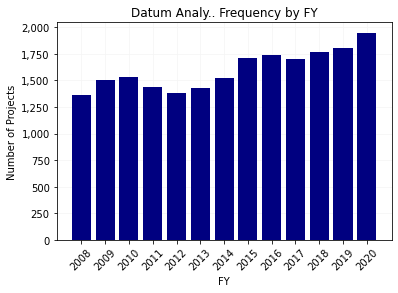

In [50]:
year = yrs_data_mining.index.tolist()
count = yrs_data_mining.values

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(year, count, color='navy')
#plt.xlim(-0.7, len(year)-0.3)
#plt.xlim(2007.3,2020.7)
plt.xticks(year, rotation=45)
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
#x_ticks = ax.xaxis.get_major_ticks()
#x_ticks[-1].label1.set_visible(False)
plt.xlabel("FY")
plt.ylabel("Number of Projects")
plt.title("Datum Analy.. Frequency by FY")

#plt.savefig("startyr_freq.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("startyr_freq.pdf", dpi = 800, bbox_inches = "tight")

In [90]:
df["ABSTRACT"][15000]

'DESCRIPTION (provided by applicant): Insulin is the primary hormone regulating glucose homeostasis. It binds to and activates the insulin receptor (IR), which subsequently tyrosine phosphorylates and activates multiple cell signaling proteins including IRS proteins, APS and SH2-B. Defects in activation of IR and/or its downstream signaling molecules result in insulin resistance, which is associated with and may be a driving force for type 2 diabetes. The long-term goal of my research program is to elucidate the molecular mechanisms of insulin signaling and resistance. We recently identified SH2-B as a binding protein for IR as well as for JAK2, a cytosolic tyrosine kinase required for cytokine action. SH2-B binds to JAK2 via its SH2 domain, and enhances JAK2 kinase activity; however, its role in insulin action is unclear. To study the physiological function of SH2-B in vivo, we generated mutant mice lacking SH2-B. Initial inspection revealed that the mutant mice homozygous for the SH2

In [5]:
docs = df["final_tokens"]  

In [91]:
#counts number of abstracts that contain 'data'
term_match_data = []
for i, abstract in enumerate(docs):
        if ('social media' in abstract):
            term_match_data.append(i)

In [92]:
len(term_match_data)

381

In [8]:
term_match_idx = []

for i, abstract in enumerate(docs):
    if ('data' in abstract): 
        if ('big' in abstract or 'mining' in abstract):
            term_match_idx.append(i)

In [9]:
len(term_match_idx) 

9327

In [10]:
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(docs)

terms = vectorizer.get_feature_names()

In [11]:
dtm.shape

(1143869, 1629626)

In [12]:
#checks for all terms relating to data 
count = 0

for term in terms:
    if 'data' in term:
        if not 'base' in term: 
#             print(term)
            count = count + 1
        
print(count)

2955


In [13]:
term_counts = dtm.sum(axis=0)

In [14]:
icount = 0
for term in terms:
    if 'data' in term:
        if 'mining' in term or 'big' in term:
            if not 'http'in term:
                print(term)
                icount = icount + 1
        
print(icount)

big_dataresearch
bigdata
bigdata_4
bigdataadministrative
bigdatasimpact
bigdatatop100org
bigdatax
biggerdata
bigreddata
biodata_mining
bydatamining
databasemining
dataexamining
datamining
dataminingtool
miningdata
16


In [15]:
#will create set of all terms with data and big or mining and list their frequency
di = {}

for i, term in enumerate(terms):
    if 'data' in term:
        if 'mining' in term or 'big' in term:
            if not 'http' in term:
        #print(term)
                di[term] = term_counts[0,i]

In [16]:
di

{'big_dataresearch': 7,
 'bigdata': 208,
 'bigdata_4': 2,
 'bigdataadministrative': 1,
 'bigdatasimpact': 1,
 'bigdatatop100org': 1,
 'bigdatax': 10,
 'biggerdata': 5,
 'bigreddata': 2,
 'biodata_mining': 14,
 'bydatamining': 3,
 'databasemining': 2,
 'dataexamining': 3,
 'datamining': 21,
 'dataminingtool': 2,
 'miningdata': 1}

In [17]:
docs_ix = np.concatenate([term_match_idx]) 

In [18]:
docs_idx = np.unique(docs_ix)

In [19]:
filt_corpus = df.loc[docs_idx, :]

In [20]:
filt_corpus = filt_corpus[~filt_corpus.PROJECT_TERMS.isnull()]

In [27]:
filt_corpus.head()

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens
245,89815,This proposal seeks to advance our understandi...,Address; Adsorption; Archives; Attention; Bioa...,COLLABORATIVE RESEARCH: EVOLUTION OF DISSOLVED...,NSF,NSF,NaN,0809254,10/1/2008,9/30/2011,"LENTERS, JOHN D","SCOTT, DURELLE",01,555456995,UNIVERSITY OF NEBRASKA LINCOLN,LINCOLN,NE,68588-0430,UNITED STATES,NaN,NaN,47.050,2008,138458.0,NaN,2,2,470378.0,2,proposal seek advance understanding transport ...
254,89807,This proposal seeks to advance our understandi...,Address; Adsorption; Archives; Attention; Bioa...,COLLABORATIVE RESEARCH: EVOLUTION OF DISSOLVED...,NSF,NSF,NaN,0809231,10/1/2008,9/30/2012,"MITCHELL, MYRON J",NaN,21,804878247,STATE UNIVERSITY NEW YORK STONY BROOK,ALBANY,NY,12201-0009,UNITED STATES,NaN,NaN,47.050,2008,70256.0,NaN,1,1,70256.0,1,proposal seek advance understanding transport ...
283,89781,The goal of the Firefly cubesat is to unambigu...,Acceleration; Altitude; Characteristics; Colla...,COLLABORATIVE RESEARCH: CUBESAT FIREFLY--UNDER...,NSF,NSF,NaN,0838015,10/1/2008,9/30/2011,"WEATHERWAX, ALLAN T",NaN,21,080481351,SIENA COLLEGE,LOUDONVILLE,NY,12211-1462,UNITED STATES,NaN,NaN,47.050,2008,329432.0,NaN,1,1,329432.0,1,goal firefly cubesat unambiguously determine t...
300,89765,This project develops novel computational appr...,Address; Algorithms; analytical tool; base; Be...,DHB: LONGITUDINAL ANALYSIS AND MODELING OF LAR...,NSF,NSF,NaN,0826958,10/1/2008,9/30/2012,"TOROCZKAI, ZOLTAN","ALBER, MARK; CHAWLA, NITESH; LIZARDO, OMAR; HA...",02,824910376,UNIVERSITY OF NOTRE DAME,NOTRE DAME,IN,46556-5612,UNITED STATES,NaN,NaN,47.075,2008,711770.0,NaN,1,1,711770.0,1,project develop novel computational approach a...
386,90167,0743933GhiorsoThis award provides funding to i...,Archives; Automatic Data Processing; Award; Co...,GEOINFORMATICS: COLLABORATIVE RESEARCH: PROPOS...,NSF,NSF,NaN,0743933,9/15/2008,8/31/2010,"GHIORSO, MARK S",NaN,08,602157450,OFM RESEARCH,REDMOND,WA,98053-8841,UNITED STATES,NaN,NaN,47.050,2008,159836.0,NaN,1,1,159836.0,1,award provide funding improve library experime...


In [21]:
wrd_frq = pd.Series(' '.join(filt_corpus.PROJECT_TERMS).split())
wrd_frq = wrd_frq.str.lower()
wrd_frq = wrd_frq.str.rstrip(";")
wrd_frq = wrd_frq.str.rstrip("s")
wrd_frq = wrd_frq.value_counts()

In [22]:
wrd_frq[0:40]

data           30710
research       23227
health          9510
system          8363
clinical        7928
development     7435
disease         6877
of              6638
science         5910
tool            5621
computer        5603
base            5556
method          5368
resource        5228
gene            5132
design          4785
human           4693
modeling        4655
biological      4549
genetic         4532
personnel       4431
proce           4400
program         4372
cell            4301
training        4239
cancer          4199
technology      4188
goal            4185
novel           4154
database        4144
study           4048
software        3893
patient         3782
learning        3748
mining          3729
protein         3671
work            3668
improved        3595
and             3571
risk            3551
dtype: int64

In [28]:
filt_corpus["FY"] = filt_corpus["FY"].astype('int')

In [30]:
year_counts = filt_corpus['FY'].value_counts().sort_index(ascending=True)
print(year_counts)

2008     382
2009     487
2010     433
2011     386
2012     433
2013     571
2014     673
2015     764
2016     884
2017     937
2018    1051
2019     673
2020     721
Name: FY, dtype: int64


In [32]:
cb_pal = {"blue":'#377eb8', "orange":'#ff7f00', "green":'#4daf4a', "pink":'#f781bf', "brown":'#a65628', 
          "purple":'#984ea3', "gray":'#999999', "red":'#e41a1c', "yellow":'#dede00'}

<ipython-input-35-d54647f0cc45>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


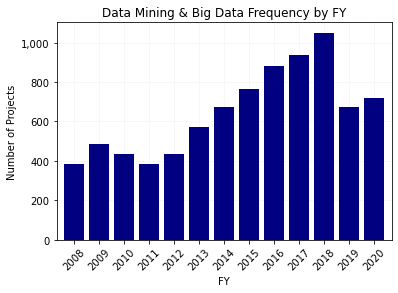

In [35]:
year = year_counts.index.tolist()
count = year_counts.values

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(year, count, color='navy')
#plt.xlim(-0.7, len(year)-0.3)
plt.xlim(2007.3,2020.7)
plt.xticks(year, rotation=45)
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
#x_ticks = ax.xaxis.get_major_ticks()
#x_ticks[-1].label1.set_visible(False)
plt.xlabel("FY")
plt.ylabel("Number of Projects")
plt.title("Data Mining & Big Data Frequency by FY")

plt.savefig("startyr_freq.png", dpi = 800, bbox_inches = "tight")
plt.savefig("startyr_freq.pdf", dpi = 800, bbox_inches = "tight")